# 需要的 Python 技巧

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from abc import ABC, abstractmethod

## 迭代器

### 范围

最经典的循环任务是从 1 到 100 相加得到 5050。这样一类任务通常由范围来实现：

In [2]:
summation = 0
for i in range(1, 101):
    summation += i
summation

5050

<div class="alert alert-warning">

**提示**

Python 的范围使用类似于“尾后指针”的迭代方式；即对于 Python 的

    for i in range(a, b):
    
而言，这等同于 C 语言的

    for (int i = a; i < b; ++i)

或者如果 `a`, `b` 分别指代一个 C++ 可迭代容器 `vector<T> vec` 的首指针 `vec.begin()` 与尾指针 `vec.end()`，那么等同于

    for (vector<T>::iterator i = vec.begin(); i < vector.end(); ++i)

由于 `b = vector.end()` 所指代的指针并不在列表 `vec` 中，它是列表最后一个元素之后的指针，因此也称为“尾后指针”。

对于 C++ 编程者而言，Python 的迭代方式可能比较直观；但对于 Fortran 编程者，这需要适应。

</div>

### 列表的浅复制问题

这里列举一些列表复制中会遇到的现象；或者跟一般地，浅复制 (shallow copy) 与深复制 (deep copy) 现象。更原理性的讨论需要参考其它资料。

这里使用到 Python 的内置库 [copy](https://docs.python.org/3/library/copy.html)。

我们先考察下述的几个变量：

In [3]:
lst = [[]] * 3
lst1 = lst
lst2 = copy.copy(lst)
lst3 = copy.deepcopy(lst)

其中，`lst1` 与 `lst` 是完全等价的，除非重新定义 `lst1`；而剩下两个变量则略有区别。这从内置函数 `id` 可以看出：

In [4]:
for l in [lst, lst1, lst2, lst3]:
    print(id(l))

139982160465800
139982160465800
139982160465672
139982160465416


即使不是所有列表的 `id` 返回值相同，但确实这些列表是相同的列表：

In [5]:
for l in [lst, lst1, lst2, lst3]:
    print(l)

[[], [], []]
[[], [], []]
[[], [], []]
[[], [], []]


In [6]:
bools = [[None] * 4 for _ in range(4)]  # construct empty list which is free from shallow copy problem
for i1, l1 in enumerate([lst, lst1, lst2, lst3]):
    for i2, l2 in enumerate([lst, lst1, lst2, lst3]):
        bools[i1][i2] = l1 == l2  # output matrix indicates identity between lists
bools

[[True, True, True, True],
 [True, True, True, True],
 [True, True, True, True],
 [True, True, True, True]]

现在我们向 `lst[1]` 的字列表中添加元素：

In [7]:
lst[1].append(1)

我们发现，除了 `lst3` 之外，其它的列表的三个字列表都变成了含有元素的列表。这与 `lst[1].append(1)` 这行程序所表达的意义完全不同：

In [8]:
for l in [lst, lst1, lst2, lst3]:
    print(l)

[[1], [1], [1]]
[[1], [1], [1]]
[[1], [1], [1]]
[[], [], []]


如果我们向 `lst3` 也作类似的操作，我们发现 `lst3` 也产生了相似的效应，但并没有对其它的三个列表也产生影响：

In [9]:
lst3[0].append(2)
for l in [lst, lst1, lst2, lst3]:
    print(l)

[[1], [1], [1]]
[[1], [1], [1]]
[[1], [1], [1]]
[[2], [2], [2]]


这意味着，`copy.deepcopy` 在大多数情况下可以将变量自身的数据与被复制变量的数据区分开，但自身变量之间的引用关系仍然保留。`copy.copy` 有时仍然引用了被复制变量的数据。这也能从调用 `id` 的输出中能看出：

In [10]:
for l in [lst, lst1, lst2, lst3]:
    print([id(val) for val in l])

[139982160465544, 139982160465544, 139982160465544]
[139982160465544, 139982160465544, 139982160465544]
[139982160465544, 139982160465544, 139982160465544]
[139982160465864, 139982160465864, 139982160465864]


同时，统一列表中的三个元素相同，意味着 `[[]] * 3` 事实上是将三个**完全相同**而非**同值**的空列表赋予了列表中。因此，对任何其中一个子空列表添加值将会对其它两个子空列表也产生影响。

下面我们并不是打算添加或更改字列表，而是将列表的元素替换。如果我们执行下述代码：

In [11]:
lst1[0] = 3
lst2[1] = 4
for l in [lst, lst1, lst2]:
    print(l)

[3, [1], [1]]
[3, [1], [1]]
[[1], 4, [1]]


我们注意到，`lst1` 作为 `lst` 的等价变量，两者都会受到元素更变的影响；但 `lst2` 作为 `lst` 的浅复制，则没有受到元素变更的影响。

我们在这里停止对列表复制的讨论。尽管浅复制通常可以减少数据在内存中的复制并提高存储效率，但也会引起一些不直观、不易调试的问题。列表复制这一小节的主要目的是提醒读者，在对包括列表、numpy 向量之内的其它 Python 对象进行操作时，需要小心可能出现的浅复制、引用等问题。同时，我们应当要知道，在 Python 中，没有任何变量是严格可以作为常量传值的；因此即使对于一些元素通过只设定 getting 函数而不设定 setting 函数进行保护，你也很可能会通过浅复制过程将这种被保护的变量的值改写。

<div class="alert alert-info">

**任务**

1. 尽管我们刚才说 `[[]] * 3` 在增添元素 `1` 时会出现期望之外的 `[[1], [1], [1]]`，但我们也使用了看起来非常类似的危险的代码 `bools = [[None] * 4 for _ in range(4)]`；事实上，这段代码在对元素赋值过程中是安全的。请尝试执行下述两个代码块，并解释输出结果。

</div>

In [12]:
bools1 = [[None] * 3 for _ in range(3)]
bools1[1][2] = 0
bools1  # Expected

[[None, None, None], [None, None, 0], [None, None, None]]

In [13]:
bools2 = [[None] * 3] * 3
bools2[1][2] = 0
bools2  # Unexpected

[[None, None, 0], [None, None, 0], [None, None, 0]]

### 类迭代器

类迭代器是一种可以由编程者自定义的迭代器。尽管平时不会构造这种迭代器，但 `pyxdh.Utilities.GridIterator` 使用了这种迭代器。`GridIterator` 类会用于 DFT 格点积分时产生原子轨道格点的过程中，因此会经常使用到。

类迭代器从使用上与列表迭代器并无二致，但对其性质与原理的理解总是有帮助的。类迭代器可以参考 [RUNOOB Python3 迭代器与生成器](https://www.runoob.com/python3/python3-iterator-generator.html)。

## 特殊的函数

### 函数作为返回值

Python 中的函数，通常来说可以使用 `def` 来定义；譬如我们定义函数输入 $x$，输出 $\sin(x)$，那么这个函数可以借助于 numpy，定义为

In [14]:
def sin(x):
    return np.sin(x)

现在我们考虑下述问题：我们希望构建下述泛函并绘制图像

$$
F[f(x)] = \sin(f(x))
$$

其中，$f$ 是函数。如果 $f(x) = x^2 + 2x$，那么这个问题就化为绘制 $\sin(x^2 + 2x)$ 图像。这可以使用代码表示如下：

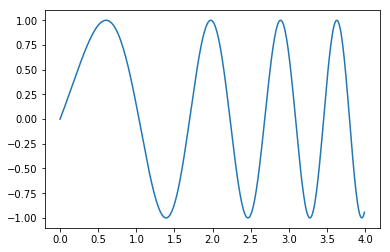

In [15]:
x_list = np.arange(0, 4, 0.01)  # x component of plot points

def f(x):
    return x ** 2 + 2 * x

plt.plot(x_list, sin(f(x_list)))

我们换一种思路。刚才，我们是通过泛函 $F[f] = sin(f)$ 与函数 $f(x) = x^2 + 2 x$ 构成新的关于 $x$ 的函数 $F[f](x)$；但我们可以不必真的构建新的函数，只需要分别构建 $F[f]$ 与 $f(x)$ 即可。$f(x)$ 我们已经通过 `f` 构建，它的传入、传出都是值；但泛函 $F[f]$ 事实上是传入、传出的是函数。因此，我们定义下述的泛函 `F`：

In [16]:
def F(f):
    def r(x):
        return np.sin(f(x))
    return r

它看起来有些绕；而其调用似乎更不直观。我们通过下述的代码绘制图像：

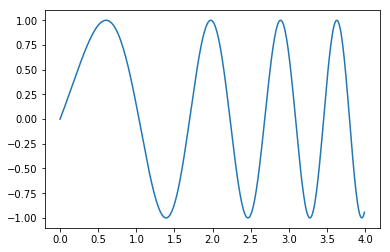

In [17]:
plt.plot(x_list, F(f)(x_list))

之所以 `F(f)(x_list)` 可以执行，是因为 `F(f)` 实际上是一个函数。

从执行过程的角度上，

- `F(f)([x1, x2])` 类似于将函数 `F[f]` 直接映射到列表 `[x1, x2]`，先得到 `F(f)(x1)`，随后得到 `F(f)(x2)`，最终将两者拼起来。

- `sin(f([x1, x2]))` 类似于先将 `f` 映射到 `[x1, x2]` 得到 `sin([f(x1), f(x2)])`，再最终将 `sin` 映射到 `[f(x1), f(x2)]`，得到 `[sin(f(x1)), sin(f(x2))]`。

尽管从这个例子来看，两种代码除了括号的位置不太一样之外并无区别，计算量也没有真正的区别；但如果我们现在将绘图程序打包成以下函数：

In [18]:
def plot_func(f):
    x_list = np.arange(0, 4, 0.01)
    plt.plot(x_list, f(x_list))

其意义是，绘图程序只通过获得 $y = f(x)$ 来获得纵坐标信息。这时，函数的输入 $f$ 就必须是一个函数，而 `sin(f(x))` 这种调用方式并不能提炼出一个函数来；反之，`F(f)` 则是一个函数。

这种通过输入函数或其它参量，返回函数的情形不会遇到太多；但在计算 CP-HF 方程时，由于对于问题 $\textbf{A} \boldsymbol{x} = \boldsymbol{b}$，$\textbf{A}$ 获得的代价太大；因此其中一个输入的参数会是 $\texttt{Ax}: \boldsymbol{x} \mapsto \textbf{A} \boldsymbol{x}$。对于这个泛函绘图的问题有所了解的话，CP-HF 方程的代码就会容易理解一些。

## 类

### 只实例化一次的属性

这是关于类的属性 (property) 的讨论。在 `pyxdh` 中，程序大量使用到属性。一般来说，属性的作用是

- 方便 \[g/s\]etting 函数调用，以及可能的代码重构；

- 可以设定一些变量不可设定，只可访问；

- 对于 Python 以外的语言，还能对 getting 与 setting 函数采取不同的可访问性。

利用这些特性，`pyxdh` 中的许多矩阵确实是只可访问的。除此之外，这些矩阵还有一个特性，即只在第一次被访问到时会执行计算；但代价是计算的结果储存到内存。我们用一个非常简单的例子解释。

In [19]:
class A:
    
    def __init__(self):
        self._var = NotImplemented
    
    @property
    def var(self):
        if self._var is NotImplemented:
            self._var = self._get_var()
        return self._var
    
    def _get_var(self):
        print("getter aquired!")
        return np.array([0, 1])

现在，我们实例化这个类，并查看弱保护变量 `_var` 的值：

In [20]:
a = A()
a._var

NotImplemented

但如果我们调用了属性 `var`，那么弱保护变量 `_var` 也同时被赋值，并经历了一次 `_get_var` 函数的调用：

In [21]:
a.var

getter aquired!


array([0, 1])

In [22]:
a._var

array([0, 1])

如果我们以后再调用属性 `var`，`_get_var` 就永远不会再执行 (除非更改 `_var` 的值为 `NotImplemented`)。

In [23]:
a.var

array([0, 1])

之所以采用这种稍繁琐的方式定义属性，一方面是希望保留编程上的便利，避免程序计算其他矩阵的时候还要检查哪些作为前置条件的矩阵没有被计算过；另一方面，由于计算矩阵都有着不小的代价，因此不希望让矩阵多次计算。

但这里要指出，由于 NumPy 经常使用引用传值 (这种说法未必正确，可能更恰当的用词是 [视图](https://www.tutorialspoint.com/numpy/numpy_copies_and_views.htm))；因此，下述的代码仍然可以改变看起来是保护变量的 `var`。这种代码疏忽很难被发现，因此编写程序时要格外注意。

In [24]:
a.var[0] = 2
a.var

array([2, 1])

### 菱形继承

在 `pyxdh` 中使用了大量菱形继承。这一般被认为不是正常的编程思路，但这个项目仍然使用之。如果只是希望使用代码或者阅读文档，那么菱形继承的理解将不那么重要；但如果打算理解 `pyxdh` 的工作原理，这一段可能是有帮助的。下面的代码是一个典型的菱形继承，同时也表明一个菱形继承的缺陷：

In [25]:
class A:
    def val(self):
        return "A printed"
    
class B(A):
    def val(self):
        return "B printed"
    
class C(A):
    def val(self):
        return "C printed"
    
class D(B, C):
    pass

这种继承关系可以图示表示为

```
  A
 / \
B   C
 \ /
  D
```

但既然 `D` 同时继承了 `B` 与 `C`，那么其 `val` 函数是否也同时继承两者？并不是如此。

In [26]:
d = D()
d.val()

'B printed'

在 Python 中，这种多继承发生定义冲突时，解决方案不是未定义的，而是通过 [MRO 或称 C3 Linearization](https://en.wikipedia.org/wiki/C3_linearization) 的方式解决的；这并非是深度优先或广度优先的类搜索，因此较为复杂；这里不进行太深入的讨论。但是由于 `pyxdh` 项目中大量使用这种菱形继承的思路，因此这里有必要对其有基本的印象，并且了解这种菱形继承所可能具有的严重缺陷或陷阱。我们通过下面一个任务来粗略地了解其中一种缺陷。

<div class="alert alert-info">

**任务**

1. 下面一个例子从编程上不是一个好的例子，但也许能帮助你了解菱形继承过程中的函数重载方式。现在我们考虑下述具有构造函数重载的菱形继承类。

    - 看起来，类 `C` 的构造函数非常不合理，因为它的父类 `A` 是无参的构造函数，但 `C` 却调用了父类的有参构造函数。确实，实例化 `C` 类的 `c = C("C")` 是不成功的。
    
    - 但下述的代码对于 `D` 的实例化 `d = D("D")` 是成功的。这从“直觉”看上去确实很不合理，因为 `D` 调用了 `C` 的构造函数，而 `C` 调用了 `A` 的构造函数；后一个过程看起来就是实例化 `C` 类，应当会与前面的 `C` 类的实例化一样不成功。
    
    请尝试使用你能想到的方法，或者使用插入打印语句、或者 IDE 断点、或者反射 (Reflection)，指出上述“直觉”是错误的。作者是通过插入打印语句大致确定原因的。
    
    正因为 Python 的菱形继承具有这种反直觉的问题，因此作者在 `pyxdh` 中，大多数与梯度有关的类均使用有且仅有一个字典参数 `config` 来初始化类，因为字典通过不同键值可以包含很多参数；但被传参时，只需要一个字典即可，不需要额外指定多个参数或可选参数。

</div>

In [27]:
class A:
    def __init__(self):
        self.var = NotImplemented
    
class B(A):
    def __init__(self, var):
        super(B, self).__init__()
        self.var = var
    
class C(A):
    def __init__(self, var):
        super(C, self).__init__(var)
    
class D(C, B):
    def __init__(self, var):
        super(D, self).__init__(var)

d = D("D")
print(d.var)

c = C("C")

D


TypeError: __init__() takes 1 positional argument but 2 were given

从上面一个任务，我们应当知道 Python 中，多个父类的继承与父类的顺序是有关的。

在完成上面一个问题的前提下，我们考虑一个更为现实但稍更复杂的问题。我们考察这样一个类：

In [28]:
from pyxdh.DerivOnce import GradXDH

这是 xDH 型泛函的一阶原子核坐标梯度的类。我们回顾到从编程序的角度上，xDH 型泛函可以看作是融合了非自洽 DFT 与基于自洽 DFT 的 MP2 方法 (但从原理上不应该这么粗浅地理解)；而 MP2 与非自洽 DFT 都是从自洽场的 DFT 方法衍生而来。同时，我们希望在计算核坐标梯度与计算偶极矩时，大多数代码能够重复用上；因此我们将偶极矩与核坐标梯度具有共性的部分整合为抽象类，而剩余的特化部分就由特化的类实现。对于 `GradXDH` 类，我们指出下述包含继承顺序信息的完整的继承关系：

- `GradXDH` 继承于 xDH 型泛函一阶梯度抽象类 `DerivOnceXDH`、MP2 核坐标梯度类 `GradMP2` 与非自洽泛函核坐标梯度类 `GradNCDFT`；

- `DerivOnceXDH` 继承于 MP2 一阶梯度抽象类 `DerivOnceMP2` 与非自洽泛函一阶梯度抽象类 `DerivOnceNCDFT`；

- `GradMP2` 继承于 `DerivOnceMP2` 与 SCF 核坐标梯度类 `GradSCF`；

- `GradNCDFT` 继承于 `DerivOnceNCDFT` 与 SCF 核坐标梯度类 `GradSCF`；

- `DerivOnceMP2`、`DerivOnceNCDFT` 都继承于 SCF 一阶梯度抽象类 `DerivOnceSCF`；

- `GradSCF` 也继承于 SCF 一阶梯度抽象类 `DerivOnceSCF`；

- 所有 `DerivOnce*` 都代表抽象类；它们都继承于 Python 自带的 `abc.ABC` 类。

其它的类，包括偶极矩 `DipoleXDH`、Hessian `HessXDH`、极化率 `PolarXDH` 类的继承关系与上述描述一致。对类的继承顺序有所了解，会对 Hacking 源代码，寻找函数的重载关系有所帮助。

<div class="alert alert-info">

**任务**

1. 请画出 `GradXDH` 类的继承关系图。与 `GradXDH` 继承图有关的类一共应当是九个。这应当是一个带帽四方棱柱型的继承关系，且“帽”是 `abc.ABC` 类。

2. (可选) 请在 PyCharm (或其它可能的 IDE) 中，找到选项绘制 `pyxdh.DerivOnce.GradXDH` 类的 Python class diagram。通常这类图是平面的 UML 图；请与你刚才画出的类继承关系图作对比。

3. (可选) 假定上述类均有构造函数，并且使用 `super(Class, self).__init__(*args, **kwargs)` 的方式初始化类。请确定在实例化 `GradXDH` 时，上述九个类的构造函数调用顺序。请注意构造函数的调用顺序会因多重继承中指定的父类顺序，譬如 `D(B, C)` 与 `D(C, B)` 的不同而不同。

</div>